In [1]:
# input
data_nodes_input_path = '..\\output\\final_data_nodes.GEOJSON'
random_seed = 4

x_cols = ['maxspeed', 'bridge', 'junction', 'building_height',
          'dist_to_train', 'dist_to_recreation', 'landuse_is_residential', 
          'landuse_is_commercial', 'landuse_is_industrial', 'rt_highway', 
          'rt_trunk', 'rt_primary', 'rt_secondary','rt_tertiary', 
          'rt_unclassified', 'rt_residential', 'rt_living_street',
          'rt_busway', 'rt_service',]
y_col = 'dBA_reg_adj'
c_cols = ['x', 'y']

In [2]:
import random
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as cx
pd.options.mode.copy_on_write = True
pd.set_option('display.max_columns', 500)
# libs
from sklearn.ensemble import RandomForestRegressor
from pykrige.rk import RegressionKriging
from sklearn.metrics import r2_score, root_mean_squared_error

import matplotlib as mpl
import matplotlib.pyplot as plt


## Model Setup

In [3]:
# input/setup
def get_new_model():
    model = RandomForestRegressor
    model_parameters = {'n_estimators': 50,
                        'max_depth': 10,
                        'min_samples_split': 10,
                        'min_samples_leaf': 4,
                        'max_features': 2,
                        'random_state': 12}
    kriging_parameters = {'n_closest_points': 20, 
                          'nlags': 6}

    return RegressionKriging(model(**model_parameters), **kriging_parameters)


## Data Setup

In [43]:
def create_spatial_folds(df, no_of_folds=16):

    def create_fold_arr(sorted_df, no_folds):
        fold_arr = np.concatenate([np.full((sorted_df.shape[0] // no_folds), i) for i in range(no_folds-1)])
        fold_arr = np.concatenate((fold_arr, np.full(sorted_df.shape[0]-len(fold_arr), no_folds-1)))
        return fold_arr
    # no_of_folds must be the square of some integer (i.e. 1,4,9,16,...)
    df = df.sort_values(by=['x', 'y']).reset_index(drop=True)
    df['xf'] = create_fold_arr(df, int(np.sqrt(no_of_folds)))
    df = df.sort_values(by=['xf', 'y']).reset_index(drop=True)
    df['fold'] = create_fold_arr(df, no_of_folds)
    return df

def spatial_train_test_split(gdf, no_test_folds, random_state=1, fold_col='fold'):
    """
    spatial folds
    """
    random.seed(random_state)
    folds = gdf[fold_col].unique()
    random.shuffle(folds)
    print(folds)
    return gdf[gdf[fold_col].isin(folds[no_test_folds:])], gdf[gdf[fold_col].isin(folds[:no_test_folds])]


# Importing data
gdf = gpd.read_file(data_nodes_input_path, engine='pyogrio')
gdf = gdf[gdf['dBA_raw'].notna()]
gdf_full = gpd.read_file(data_nodes_input_path, engine='pyogrio')
gdf_lu = gdf[gdf['sub_area'] == 'Lunetten']
# Defining spatial folds
gdf = create_spatial_folds(gdf, 16)
gdf_train, gdf_test = spatial_train_test_split(gdf.dropna(), 6, random_state=random_seed)

gdf_lu = create_spatial_folds(gdf_lu, 16)
gdf_lu_train, gdf_lu_test = spatial_train_test_split(gdf_lu.dropna(), 4, random_state=random_seed)
# Utilities for retrieving x/y/coordinate arrays
def get_x_arr(df, cols=x_cols):
    return df[cols].values
def get_y_arr(df, col):
    # print(col)
    return df[col].values
def get_c_arr(df, cols=c_cols):
    return df[cols].values
def get_train_inputs(gdf, target):
    return {'p': get_x_arr(gdf), 'x': get_c_arr(gdf), 'y': get_y_arr(gdf, col=target)}

def get_test_inputs(gdf):
    return {'p': get_x_arr(gdf), 'x': get_c_arr(gdf)}

def get_scoring_inputs(gdf, true_col, pred):
    return {'y_true': get_y_arr(gdf, col=true_col), 'y_pred': pred}
    


[10  5 12  9 14  3  0  8 13  2 15  6 11  1  4  7]
[10  5 12  9 14  3  0  8 13  2 15  6 11  1  4  7]


## Defining different model versions

In [44]:
gdf.columns

Index(['y', 'x', 'dBA_rivm', 'no_observations', 'speed', 'speed_slt20',
       'dBA_raw', 'dBA_raw_slt20', 'dBA_noise_red', 'dBA_noise_red_slt20',
       'dBA_reg_adj', 'dBA_reg_adj_slt20', 'dBA_dual_red',
       'dBA_dual_red_slt20', 'maxspeed', 'bridge', 'junction', 'rt_highway',
       'rt_trunk', 'rt_primary', 'rt_secondary', 'rt_tertiary',
       'rt_unclassified', 'rt_residential', 'rt_living_street', 'rt_busway',
       'rt_service', 'sub_area', 'dist_to_train', 'dist_to_recreation',
       'landuse_is_residential', 'landuse_is_commercial',
       'landuse_is_industrial', 'building_height', 'geometry', 'xf', 'fold'],
      dtype='object')

In [71]:
model_dict = {}
for noise_reduction in ('dBA_raw', 'dBA_noise_red', 'dBA_reg_adj', 'dBA_dual_red'):
    model_dict[noise_reduction] = {}
    for speed in ('any', 'lt20'):
        model_dict[noise_reduction][speed] = {}
        dBA_column = noise_reduction  
        if speed == 'lt20': dBA_column = f'{noise_reduction}_slt20'
        for training_area in ('full', 'Lunetten'):
            print(dBA_column, training_area)
            data = gdf_train if training_area == 'full' else gdf_lu_train
            data = data[data[dBA_column].notna()]

            model_dict[noise_reduction][speed][training_area] = get_new_model()
            model_dict[noise_reduction][speed][training_area].fit(
                data[x_cols].values, data[c_cols].values, data[dBA_column].values)

print(model_dict)



dBA_raw full
Finished learning regression model
Finished kriging residuals
dBA_raw Lunetten
Finished learning regression model
Finished kriging residuals
dBA_raw_slt20 full
Finished learning regression model
Finished kriging residuals
dBA_raw_slt20 Lunetten
Finished learning regression model
Finished kriging residuals
dBA_noise_red full
Finished learning regression model
Finished kriging residuals
dBA_noise_red Lunetten
Finished learning regression model
Finished kriging residuals
dBA_noise_red_slt20 full
Finished learning regression model
Finished kriging residuals
dBA_noise_red_slt20 Lunetten
Finished learning regression model
Finished kriging residuals
dBA_reg_adj full
Finished learning regression model
Finished kriging residuals
dBA_reg_adj Lunetten
Finished learning regression model
Finished kriging residuals
dBA_reg_adj_slt20 full
Finished learning regression model
Finished kriging residuals
dBA_reg_adj_slt20 Lunetten
Finished learning regression model
Finished kriging residuals


## Quantative Evaluation

In [72]:
def csvprint(s, end=False):
    if end:
        print(s)
    else:
        print(s, end=' ')

for noise_reduction in ('dBA_raw', 'dBA_noise_red', 'dBA_reg_adj', 'dBA_dual_red'):
    for speed in ('any', 'lt20'):
        for training_area in ('full', 'Lunetten'):
            m = model_dict[noise_reduction][speed][training_area]
            dBA_column = noise_reduction  
            if speed == 'lt20': dBA_column = f'{noise_reduction}_slt20'

            csvprint(noise_reduction[4:])
            csvprint(speed)
            if training_area == 'Lunetten': csvprint('lune') 
            else: csvprint(training_area)

            for test_area in ('Lunetten', 'Overvecht', 'Science Park', 'any'):
                csvprint('.')
                gdf_t = gdf_test
                if test_area != 'any': gdf_t = gdf_t[gdf_t['sub_area'] == test_area]

                pred = m.predict(**get_test_inputs(gdf_t))
                r2 = r2_score(**get_scoring_inputs(gdf_t, dBA_column, pred))
                csvprint(f'{r2:.3f}')
                rmse = root_mean_squared_error(**get_scoring_inputs(gdf_t, dBA_column, pred))
                if test_area !='any': csvprint(f'{rmse:.3f}')
                else: csvprint(f'{rmse:.3f}', end=True)
        


            # data = gdf_train if training_area == 'full' else gdf_lu_train
            #  = get_new_model()
            # model_dict[noise_reduction][speed][training_area].fit(**get_train_inputs(data, dBA_column))

# print(model_dict)

"""
raw any full . 0.123 7.338 . -0.039 4.213 . -0.136 5.545 . 0.238 6.069
raw any lune . 0.677 4.453 . -0.837 5.603 . -1.054 7.454 . 0.198 6.227
raw lt20 full . 0.069 5.023 . -0.052 4.222 . -0.180 5.514 . 0.044 5.144
raw lt20 lune . 0.562 3.444 . -1.654 6.704 . -1.418 7.894 . -0.495 6.434
noise_red any full . 0.138 7.273 . -0.047 4.232 . -0.160 5.552 . 0.239 6.046
noise_red any lune . 0.685 4.401 . -0.843 5.615 . -1.066 7.410 . 0.202 6.190
noise_red lt20 full . 0.060 5.084 . -0.054 4.280 . -0.200 5.494 . 0.033 5.163
noise_red lt20 lune . 0.564 3.461 . -1.661 6.801 . -1.485 7.906 . -0.515 6.462
reg_adj any full . 0.228 3.619 . -0.039 4.062 . -0.093 4.482 . 0.207 4.122
reg_adj any lune . 0.742 2.092 . -0.666 5.143 . -1.029 6.107 . -0.107 4.871
reg_adj lt20 full . 0.096 4.257 . -0.059 4.202 . -0.116 4.910 . 0.078 4.571
reg_adj lt20 lune . 0.567 2.945 . -0.769 5.432 . -1.409 7.215 . -0.447 5.727
dual_red any full . 0.226 3.675 . -0.062 4.134 . -0.075 4.439 . 0.204 4.130
dual_red any lune . 0.733 2.158 . -0.603 5.078 . -0.953 5.983 . -0.074 4.796
dual_red lt20 full . 0.055 4.407 . -0.065 4.276 . -0.099 4.887 . 0.066 4.621
dual_red lt20 lune . 0.583 2.927 . -0.767 5.508 . -1.206 6.925 . -0.353 5.563

"""

raw any full . 0.342 6.601 . -0.350 4.536 . -0.131 4.827 . 0.172 5.294
raw any lune . 0.597 5.165 . -1.428 6.084 . -1.240 6.795 . -0.163 6.278
raw lt20 full . 0.216 4.063 . -0.465 4.770 . -0.182 4.525 . -0.056 4.459
raw lt20 lune . 0.310 3.813 . -2.145 6.990 . -2.122 7.354 . -1.278 6.549
noise_red any full . 0.334 6.638 . -0.314 4.475 . -0.162 4.947 . 0.158 5.357
noise_red any lune . 0.597 5.160 . -1.335 5.965 . -1.221 6.841 . -0.158 6.283
noise_red lt20 full . 0.218 4.138 . -0.345 4.622 . -0.234 4.667 . -0.063 4.528
noise_red lt20 lune . 0.311 3.883 . -1.960 6.857 . -1.984 7.257 . -1.172 6.472
reg_adj any full . 0.290 4.245 . -0.436 4.468 . -0.107 4.128 . 0.043 4.224
reg_adj any lune . 0.447 3.748 . -0.919 5.165 . -1.011 5.563 . -0.383 5.077
reg_adj lt20 full . 0.178 4.062 . -0.452 4.619 . -0.272 4.663 . -0.109 4.507
reg_adj lt20 lune . 0.237 3.913 . -1.425 5.968 . -1.863 6.998 . -1.061 6.145
dual_red any full . 0.294 4.274 . -0.398 4.420 . -0.124 4.276 . 0.038 4.303
dual_red any lune

'\nraw any full . 0.123 7.338 . -0.039 4.213 . -0.136 5.545 . 0.238 6.069\nraw any lune . 0.677 4.453 . -0.837 5.603 . -1.054 7.454 . 0.198 6.227\nraw lt20 full . 0.069 5.023 . -0.052 4.222 . -0.180 5.514 . 0.044 5.144\nraw lt20 lune . 0.562 3.444 . -1.654 6.704 . -1.418 7.894 . -0.495 6.434\nnoise_red any full . 0.138 7.273 . -0.047 4.232 . -0.160 5.552 . 0.239 6.046\nnoise_red any lune . 0.685 4.401 . -0.843 5.615 . -1.066 7.410 . 0.202 6.190\nnoise_red lt20 full . 0.060 5.084 . -0.054 4.280 . -0.200 5.494 . 0.033 5.163\nnoise_red lt20 lune . 0.564 3.461 . -1.661 6.801 . -1.485 7.906 . -0.515 6.462\nreg_adj any full . 0.228 3.619 . -0.039 4.062 . -0.093 4.482 . 0.207 4.122\nreg_adj any lune . 0.742 2.092 . -0.666 5.143 . -1.029 6.107 . -0.107 4.871\nreg_adj lt20 full . 0.096 4.257 . -0.059 4.202 . -0.116 4.910 . 0.078 4.571\nreg_adj lt20 lune . 0.567 2.945 . -0.769 5.432 . -1.409 7.215 . -0.447 5.727\ndual_red any full . 0.226 3.675 . -0.062 4.134 . -0.075 4.439 . 0.204 4.130\ndual_r

## Prediction Plots for Comparison

dBA_raw any full dBA_raw


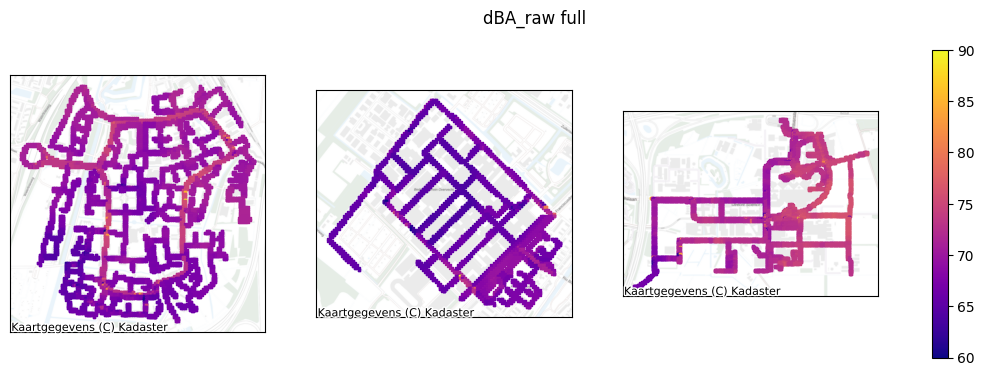

dBA_raw any Lunetten dBA_raw


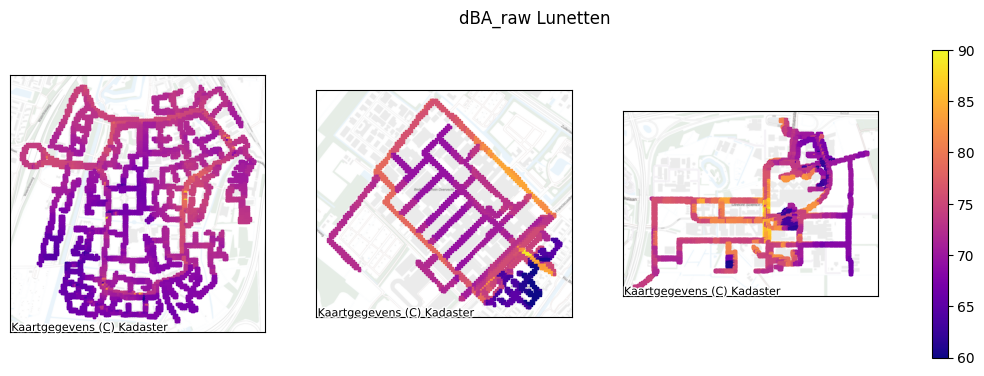

dBA_raw lt20 full dBA_raw_slt20


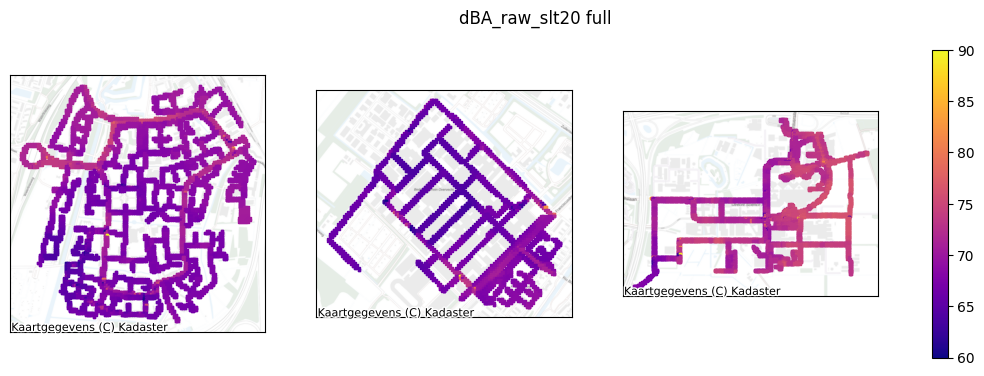

dBA_raw lt20 Lunetten dBA_raw_slt20


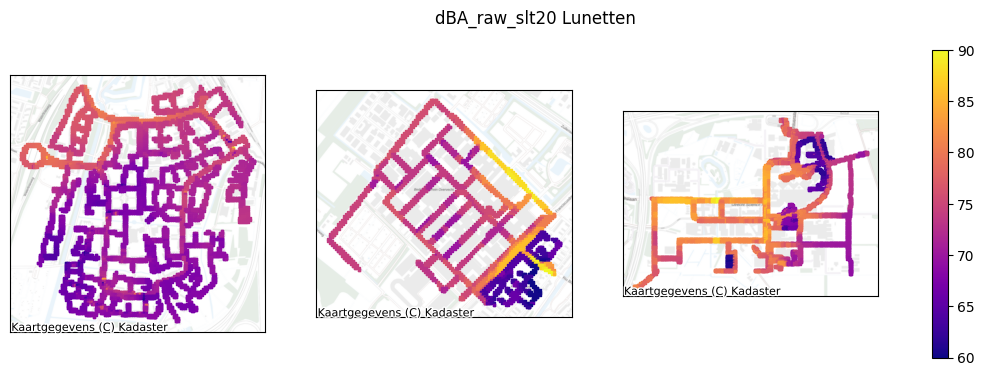

dBA_noise_red any full dBA_noise_red


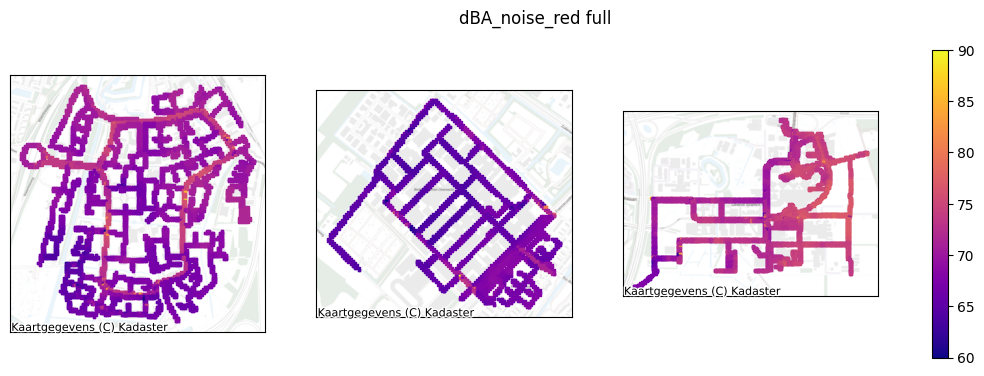

dBA_noise_red any Lunetten dBA_noise_red


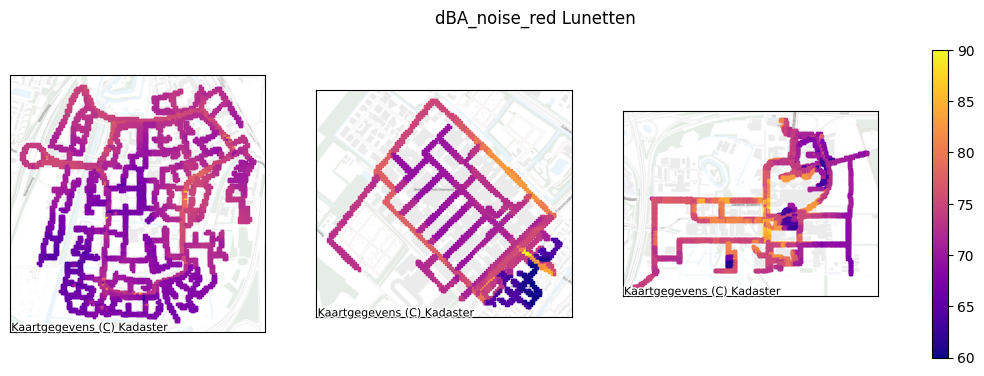

dBA_noise_red lt20 full dBA_noise_red_slt20


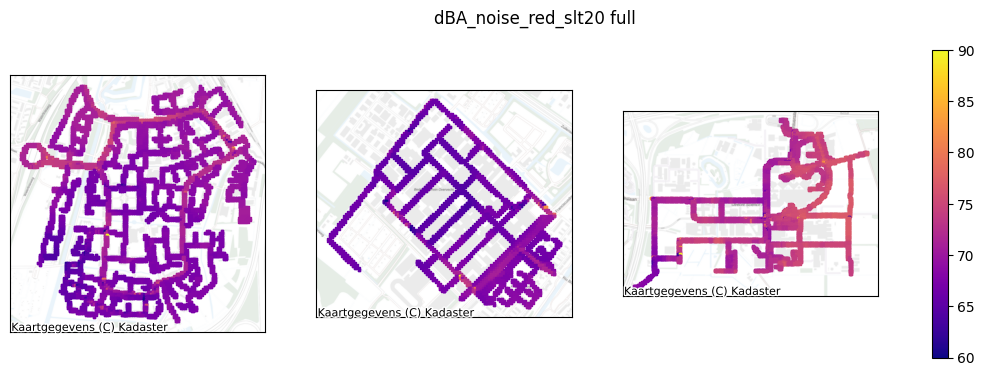

dBA_noise_red lt20 Lunetten dBA_noise_red_slt20


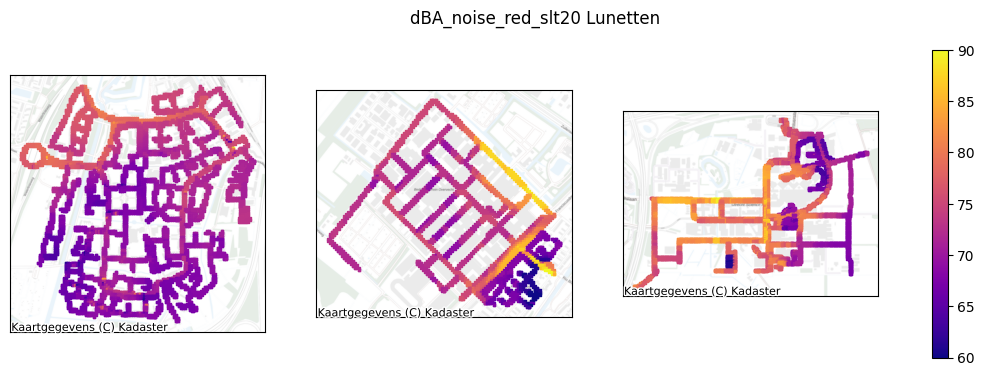

dBA_reg_adj any full dBA_reg_adj


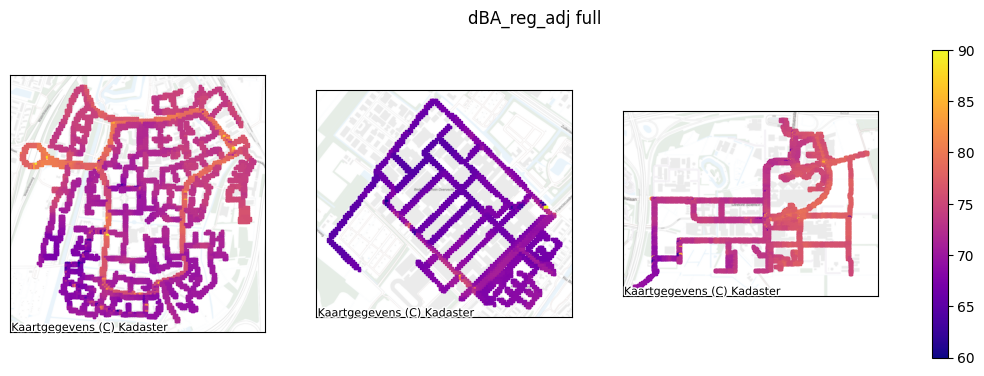

dBA_reg_adj any Lunetten dBA_reg_adj


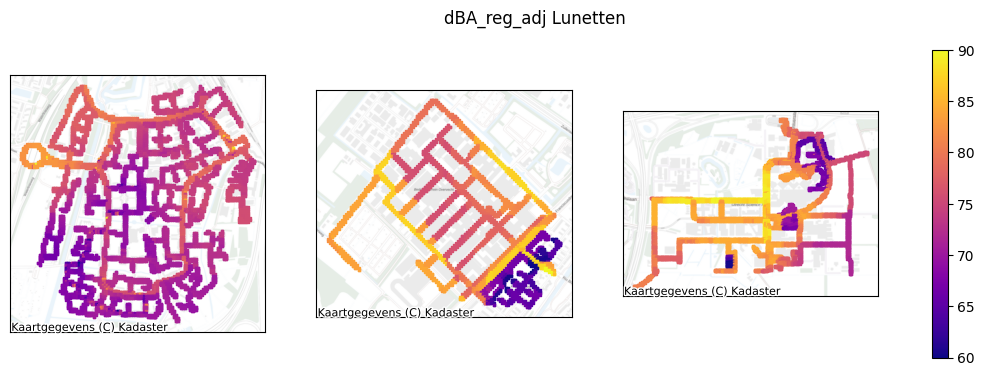

dBA_reg_adj lt20 full dBA_reg_adj_slt20


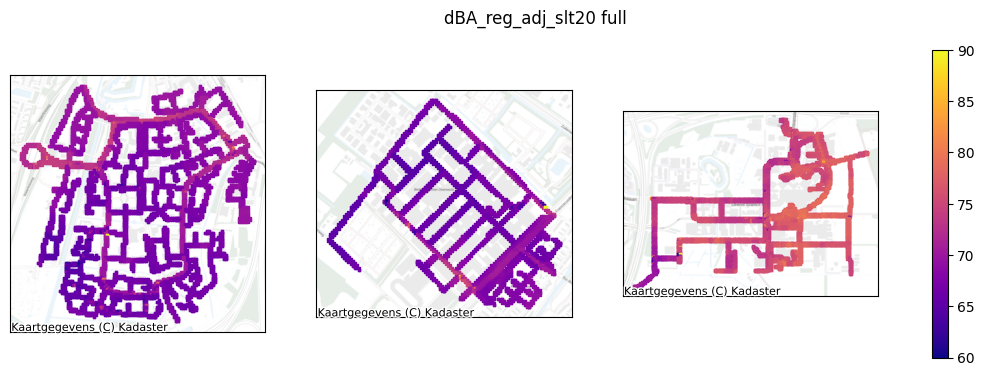

dBA_reg_adj lt20 Lunetten dBA_reg_adj_slt20


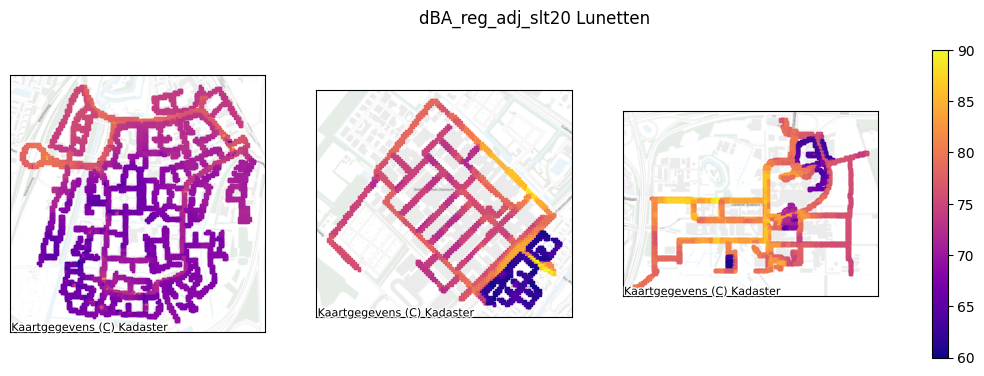

dBA_dual_red any full dBA_dual_red


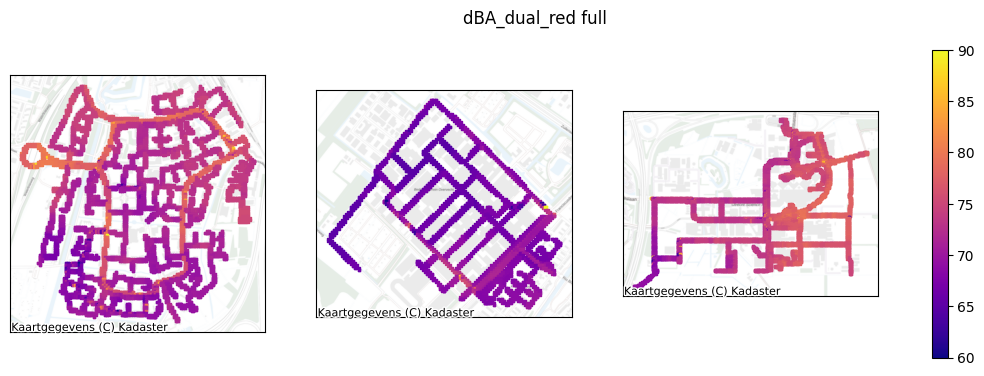

dBA_dual_red any Lunetten dBA_dual_red


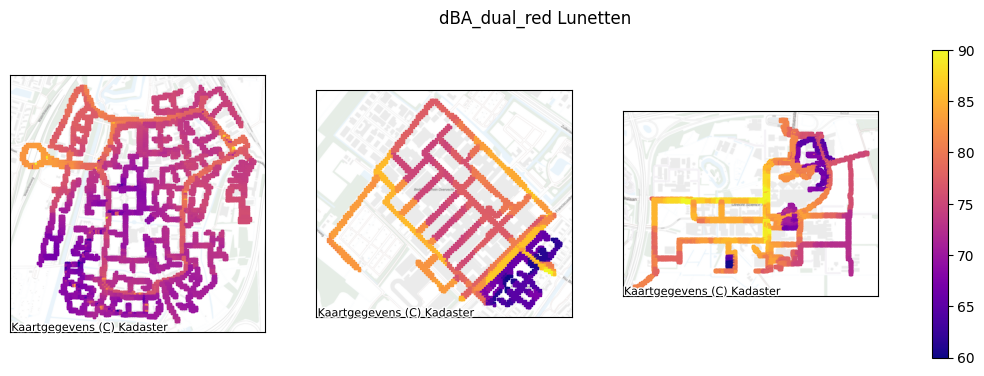

dBA_dual_red lt20 full dBA_dual_red_slt20


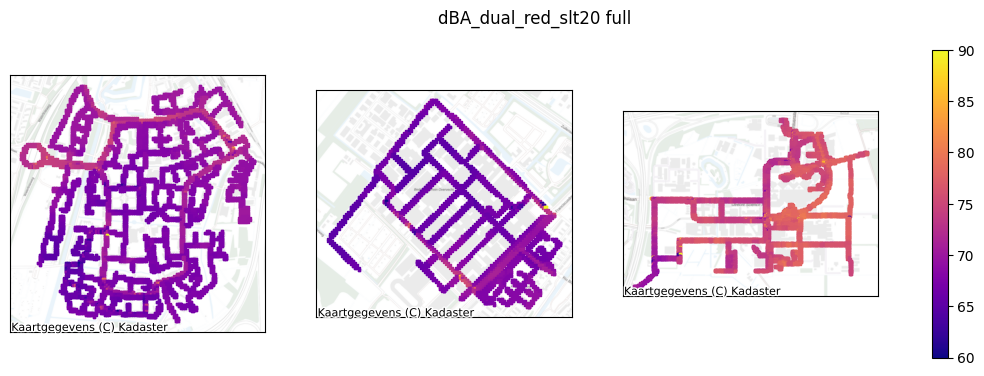

dBA_dual_red lt20 Lunetten dBA_dual_red_slt20


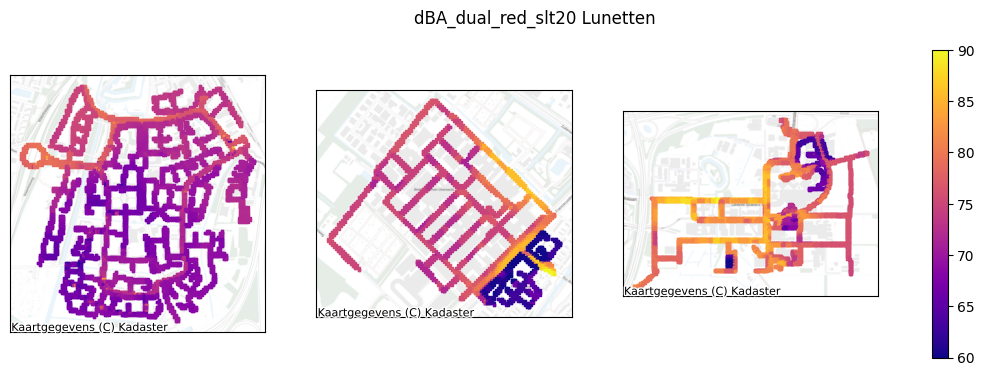

In [77]:
cmap = mpl.colormaps['plasma']
norm = mpl.colors.Normalize(vmin=60, vmax=90)
def generate_map():
    return

for noise_reduction in ('dBA_raw', 'dBA_noise_red', 'dBA_reg_adj', 'dBA_dual_red'):
    for speed in ('any', 'lt20'):
        for training_area in ('full', 'Lunetten'):
            m = model_dict[noise_reduction][speed][training_area]
            dBA_column = noise_reduction  
            if speed == 'lt20': dBA_column = f'{noise_reduction}_slt20'
            gdf_p = gdf_full
            gdf_p['pred'] = m.predict(gdf_p[x_cols].values, gdf_p[c_cols].values)

            print(noise_reduction, speed, training_area, dBA_column)

            fig, axs = plt.subplots(1,3, figsize=(14,4))
            for i, test_area in enumerate(('Lunetten', 'Overvecht', 'Science Park')):
                gdf_p[gdf_p['sub_area'] == test_area].plot(column='pred', cmap=cmap, ax=axs[i], #norm=norm,
                                                           marker='s', markersize=3)
                cx.add_basemap(ax=axs[i], source=cx.providers.nlmaps.grijs, crs=gdf_p.crs)
                axs[i].set_xticks([]); axs[i].set_yticks([])
            fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs)
            fig.suptitle(f'{dBA_column} {training_area}')
            plt.show()
            # print(gdf_p['pred'].min(), gdf_p['pred'].max())
        
    

            # data = gdf_train if training_area == 'full' else gdf_lu_train
            #  = get_new_model()
            # model_dict[noise_reduction][speed][training_area].fit(**get_train_inputs(data, dBA_column))

# print(model_dict)



dBA rivm


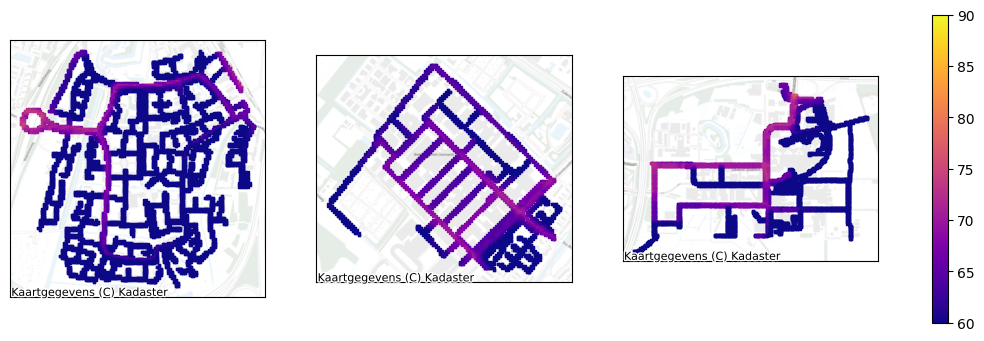

In [48]:
print('dBA rivm')
fig, axs = plt.subplots(1,3, figsize=(14,4))
for i, test_area in enumerate(('Lunetten', 'Overvecht', 'Science Park')):
    gdf_p[gdf_p['sub_area'] == test_area].plot(column='dBA_rivm', cmap=cmap, norm=norm, ax=axs[i],
                                                marker='s', markersize=3)
    cx.add_basemap(ax=axs[i], source=cx.providers.nlmaps.grijs, crs=gdf_p.crs)
    axs[i].set_xticks([]); axs[i].set_yticks([])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs)
plt.show()

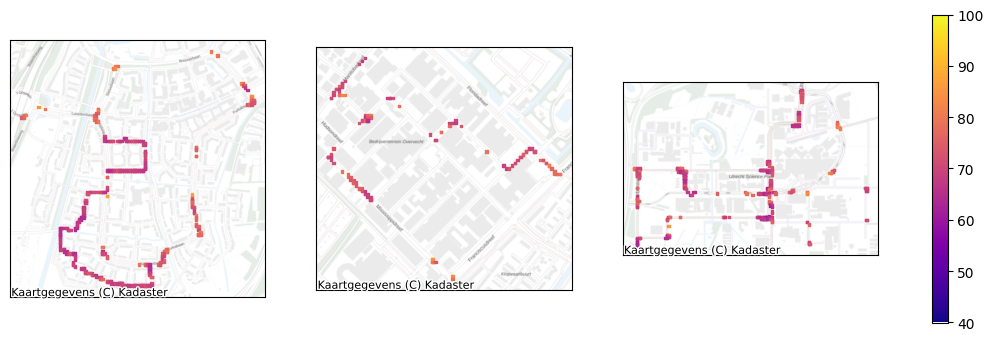

In [10]:
fig, axs = plt.subplots(1,3, figsize=(14,4))
for i, test_area in enumerate(('Lunetten', 'Overvecht', 'Science Park')):
    gdf_p[gdf_p['sub_area'] == test_area].plot(column='dBA_raw_slt20', cmap=cmap, norm=norm, ax=axs[i],
                                                marker='s', markersize=3)
    cx.add_basemap(ax=axs[i], source=cx.providers.nlmaps.grijs, crs=gdf_p.crs)
    axs[i].set_xticks([]); axs[i].set_yticks([])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs)
plt.show()

dBA_raw


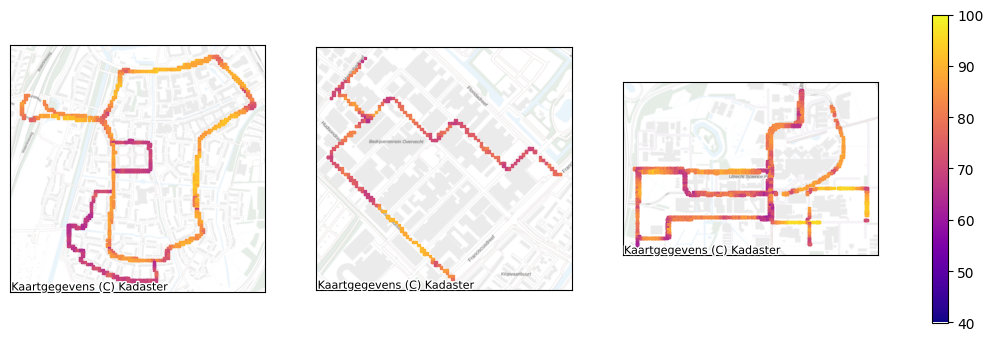

dBA_noise_red


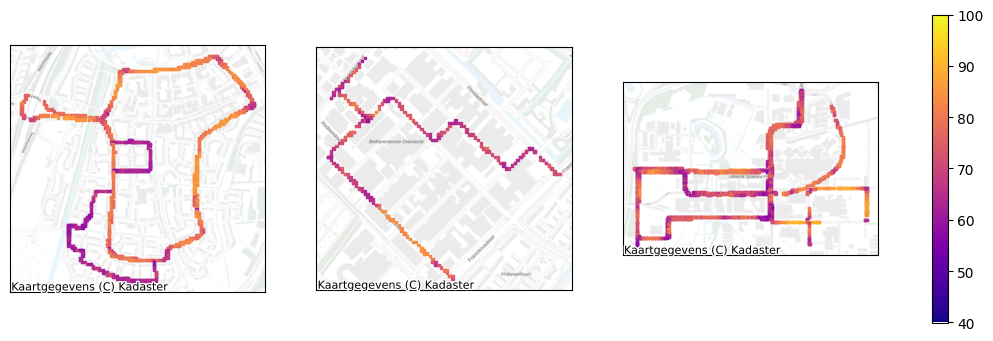

dBA_reg_adj


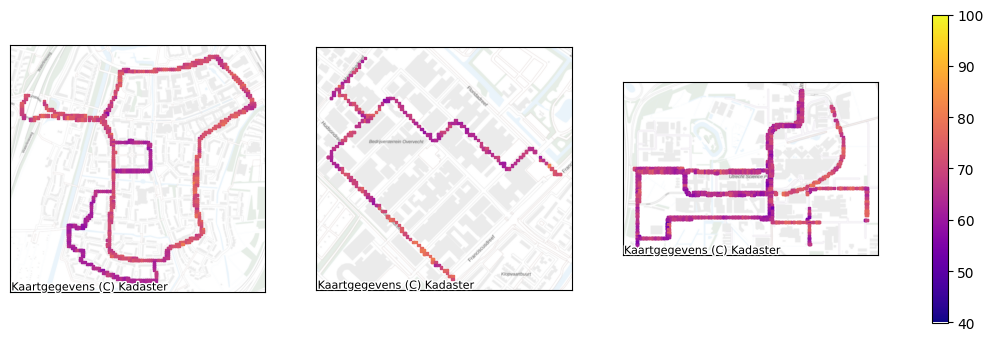

dBA_dual_red


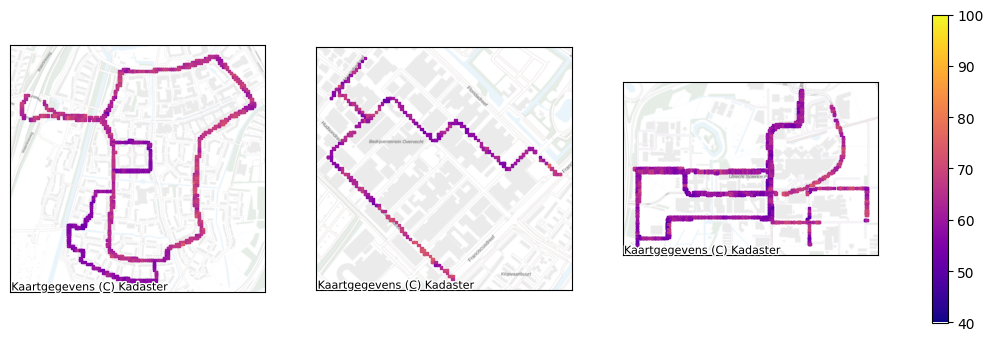

In [11]:
for noise_reduction in ('dBA_raw', 'dBA_noise_red', 'dBA_reg_adj', 'dBA_dual_red'):
    print(noise_reduction)
    fig, axs = plt.subplots(1,3, figsize=(14,4))
    for i, test_area in enumerate(('Lunetten', 'Overvecht', 'Science Park')):
        gdf_p[gdf_p['sub_area'] == test_area].plot(column=noise_reduction, cmap=cmap, norm=norm, ax=axs[i],
                                                    marker='s', markersize=3)
        cx.add_basemap(ax=axs[i], source=cx.providers.nlmaps.grijs, crs=gdf_p.crs)
        axs[i].set_xticks([]); axs[i].set_yticks([])
    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs)
    plt.show()

<Axes: title={'center': 'dBA_raw'}, xlabel='sub_area', ylabel='dBA'>

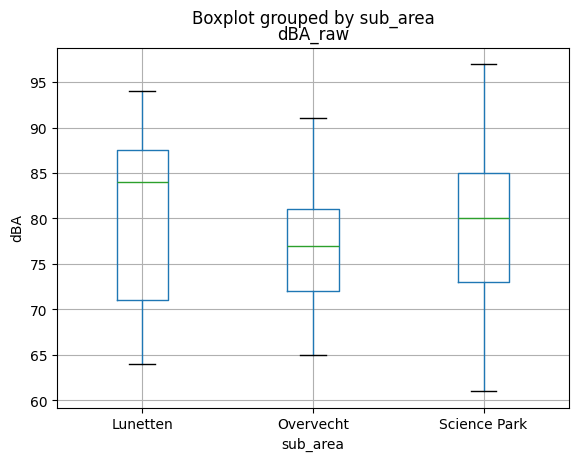

In [12]:
gdf_full.boxplot(column=['dBA_raw'], by='sub_area', ylabel='dBA')

In [13]:
gdf[gdf['speed'] != gdf['speed_slt20']]

y         x  dBA_rivm  no_observations      speed  speed_slt20  \
71   452955.0  137135.0        72                3  12.132974    12.030968   
72   452985.0  137225.0        71                2  21.540613    19.912333   
73   452995.0  137195.0        71                2  20.285886    19.210738   
79   459525.0  134565.0        70                2  17.288344    13.746316   
80   459525.0  134565.0        70                2  17.288344    13.746316   
..        ...       ...       ...              ...        ...          ...   
752  455395.0  140555.0        70                3  16.651270    16.487318   
757  455415.0  140555.0        70                3  17.061085    14.570190   
761  455655.0  140715.0        73                3  20.007518    19.712233   
776  455745.0  140755.0        72                2  23.557531    18.890789   
777  455815.0  140775.0        71                3  20.336123    17.350913   

     dBA_raw  dBA_raw_slt20  dBA_noise_red  dBA_noise_red_slt20  dBA_reg_adj  \
71      82.0           81.0           76.0                 75.0         77.0   
72      80.0           80.0           74.0                 74.0         71.0   
73      84.5           85.0           78.5                 79.0         76.0   
79      86.5           85.0           80.5                 79.0         80.0   
80      86.5           85.0           80.5                 79.0         80.0   
..       ...            ...            ...                  ...          ...   
752     74.0           72.5           68.0                 66.5         67.0   
757     66.0           65.5           60.0                 59.5         61.0   
761     68.0           66.0           62.0                 60.0         60.0   
776     68.0           67.0           62.0                 61.0         57.5   
777     78.0           75.0           72.0                 69.0         69.0   

     dBA_reg_adj_slt20  dBA_dual_red  dBA_dual_red_slt20  maxspeed  bridge  \
71                76.0          71.0                70.0        50   False   
72                72.0          65.5                66.0        50   False   
73                77.0          70.0                71.0        50   False   
79                80.0          74.0                74.0        50   False   
80                80.0          74.0                74.0        50   False   
..                 ...           ...                 ...       ...     ...   
752               66.0          61.0                60.0        50   False   
757               60.0          55.0                54.0        50   False   
761               58.0          54.0                52.0        50   False   
776               59.0          51.5                53.0        80   False   
777               68.0          63.0                62.0        80   False   

     junction  rt_highway  rt_trunk  rt_primary  rt_secondary  rt_tertiary  \
71       True       False     False       False          True        False   
72      False       False     False       False         False         True   
73      False       False     False       False         False         True   
79      False       False     False       False         False         True   
80      False       False     False       False         False         True   
..        ...         ...       ...         ...           ...          ...   
752     False       False     False       False          True        False   
757     False       False     False       False          True        False   
761     False       False     False       False          True        False   
776     False       False     False       False          True        False   
777     False       False     False       False          True        False   

     rt_unclassified  rt_residential  rt_living_street  rt_busway  rt_service  \
71             False           False             False      False       False   
72             False           False             False      False       False 

<Axes: >

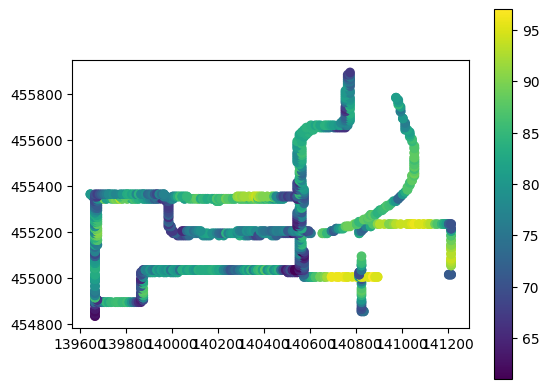

In [26]:
gdf[gdf['sub_area'] == 'Science Park'].plot(column='dBA_raw', legend=True)

<Axes: >

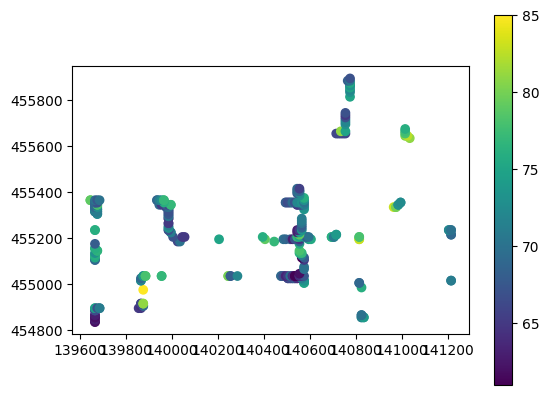

In [27]:
gdf[gdf['sub_area'] == 'Science Park'].plot(column='dBA_raw_slt20', legend=True)

In [53]:
get_train_inputs(gdf_train, 'dBA_raw_slt20')['y'] == get_train_inputs(gdf_train, 'dBA_raw')['y']

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False,  True,  True, False,  True,
        True,  True,  True,  True,  True, False, False, False,  True,
        True, False,  True,  True,  True,  True,  True, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False, False,

array([71.5, 71.5, 74. , 74. , 77. , 68. , 68. , 70. , 70. , 72. , 72. ,
       69. , 66. , 71. , 71. , 72. , 72. , 73. , 73. , 71. , 69.5, 67. ,
       67. , 67. , 69. , 69.5, 69.5, 67.5, 67. , 69. , 82.5, 82.5, 67.5,
       67.5, 74. , 65. , 69. , 73.5, 65. , 65. , 64.5, 81. , 81. , 76.5,
       66. , 66. , 66. , 68. , 69. , 68. , 68. , 66. , 80. , 80. , 67. ,
       69. , 69. , 68. , 67. , 67. , 65. , 65. , 65.5, 65.5, 66. , 66. ,
       65.5, 65.5, 69. , 69. , 70. , 64. , 64. , 64. , 65.5, 65.5, 66.5,
       68. , 68. , 65. , 65. , 66. , 67. , 67. , 68. , 68. , 67. , 67. ,
       67. , 67. , 67. , 67. , 64. , 64. , 64. , 65. , 67. , 67. , 68. ,
       69. , 69. , 69. , 67. , 67. , 69. , 69. , 72. , 72. , 86. , 86. ,
       72. , 72. , 70.5, 70. , 70. , 70. , 72. , 71. , 72. , 71. , 71. ,
       70. , 66. , 66. , 85. , 84.5, 86. , 86. , 74.5, 81.5, 83.5, 79. ,
       82. , 79. , 77.5, 74. , 77. , 77. , 76. , 77. , 82. , 78. , 74. ,
       76.5, 75. , 77.5, 77.5, 80. , 78. , 78. , 84

## Manual vs util test

In [68]:
all(gdf_train['dBA_raw_slt20'].values == get_train_inputs(gdf_train, 'dBA_raw_slt20')['y'])

True

In [63]:
get_train_inputs(gdf_train, 'dBA_raw')['y']

array([71.5, 71.5, 74. , 74. , 77. , 68. , 68. , 70. , 70. , 72. , 72. ,
       69. , 66. , 71. , 71. , 72. , 72. , 73. , 73. , 71. , 69.5, 67. ,
       67. , 67. , 69. , 69.5, 69.5, 67.5, 67. , 69. , 82.5, 82.5, 67.5,
       67.5, 74. , 65. , 69. , 73.5, 65. , 65. , 64.5, 81. , 81. , 76.5,
       66. , 66. , 66. , 68. , 69. , 68. , 68. , 66. , 80. , 80. , 67. ,
       69. , 69. , 68. , 67. , 67. , 65. , 65. , 65.5, 65.5, 66. , 66. ,
       65.5, 65.5, 69. , 69. , 70. , 64. , 64. , 64. , 65.5, 65.5, 66.5,
       68. , 68. , 65. , 65. , 66. , 67. , 67. , 68. , 68. , 67. , 67. ,
       67. , 67. , 67. , 67. , 64. , 64. , 64. , 65. , 67. , 67. , 68. ,
       69. , 69. , 69. , 67. , 67. , 69. , 69. , 72. , 72. , 86. , 86. ,
       72. , 72. , 70.5, 70. , 70. , 70. , 72. , 71. , 72. , 71. , 71. ,
       70. , 66. , 66. , 85. , 84.5, 86. , 86. , 74.5, 81.5, 83.5, 79. ,
       82. , 79. , 77.5, 74. , 77. , 77. , 76. , 77. , 82. , 78. , 74. ,
       76.5, 75. , 77.5, 77.5, 80. , 78. , 78. , 84

Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals


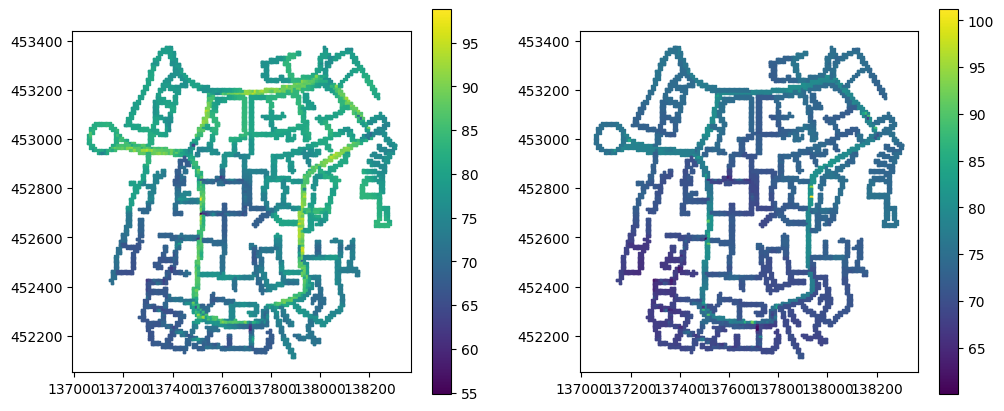

In [69]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,5))

m = get_new_model()
m.fit(gdf[x_cols].values, gdf[c_cols].values, gdf['dBA_raw'].values)
p = m.predict(**get_test_inputs(gdf_full))
gdf_full['pred'] = p
gdf_full[gdf_full['sub_area'] == 'Lunetten'].plot(column='pred', legend=True, markersize=2, marker='s', ax=ax0)

m = get_new_model()
m.fit(**get_train_inputs(gdf_train, 'dBA_raw'))
p = m.predict(**get_test_inputs(gdf_full))
gdf_full['pred'] = p
gdf_full[gdf_full['sub_area'] == 'Lunetten'].plot(column='pred', legend=True, markersize=2, marker='s', ax=ax1)

plt.show()

<Axes: >

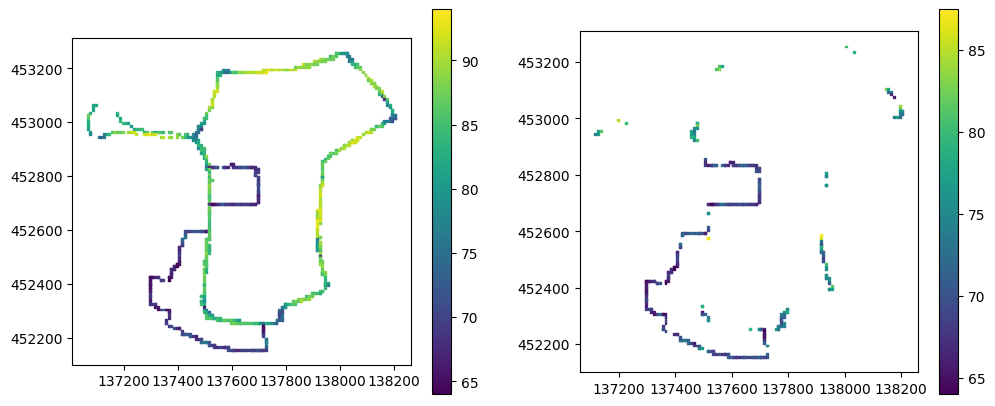

In [41]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,5))

# m = get_new_model()
# m.fit(**get_train_inputs(gdf_train, 'dBA_raw'))
# p = m.predict(**get_test_inputs(gdf_full))
# gdf_full['pred'] = p
gdf_full[gdf_full['sub_area'] == 'Lunetten'].plot(column='dBA_raw', legend=True, markersize=2, marker='s', ax=ax0)

# m = get_new_model()
# m.fit(**get_train_inputs(gdf_train, 'dBA_raw_slt20'))
# p = m.predict(**get_test_inputs(gdf_full))
# gdf_full['pred'] = p
gdf_full[gdf_full['sub_area'] == 'Lunetten'].plot(column='dBA_raw_slt20', legend=True, markersize=2, marker='s', ax=ax1)

Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals


<Axes: >

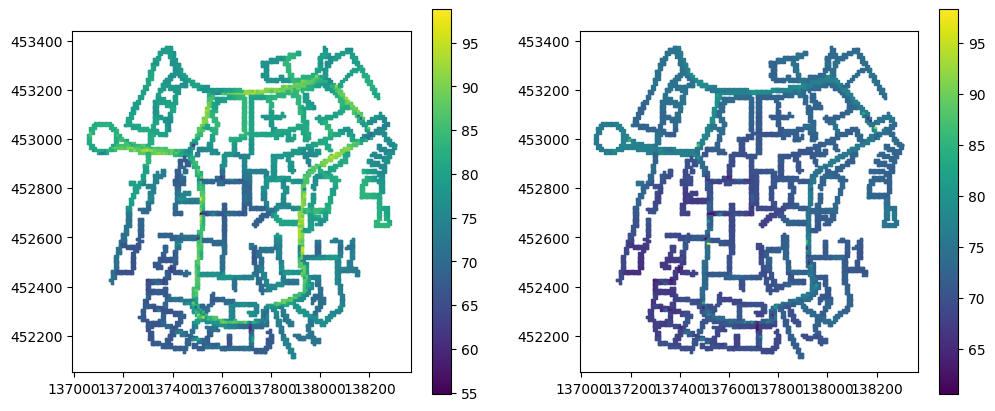

In [55]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,5))

m = get_new_model()
m.fit(gdf[x_cols].values, gdf[c_cols].values, gdf['dBA_raw'].values)
p = m.predict(**get_test_inputs(gdf_full))
gdf_full['pred'] = p
gdf_full[gdf_full['sub_area'] == 'Lunetten'].plot(column='pred', legend=True, markersize=2, marker='s', ax=ax0)

m = get_new_model()
gdf_temp = gdf[gdf['dBA_raw_slt20'].notna()]
m.fit(gdf_temp[x_cols].values, gdf_temp[c_cols].values, gdf_temp['dBA_raw_slt20'].values)
p = m.predict(**get_test_inputs(gdf_full))
gdf_full['pred'] = p
gdf_full[gdf_full['sub_area'] == 'Lunetten'].plot(column='pred', legend=True, markersize=2, marker='s', ax=ax1)

Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals


<Axes: >

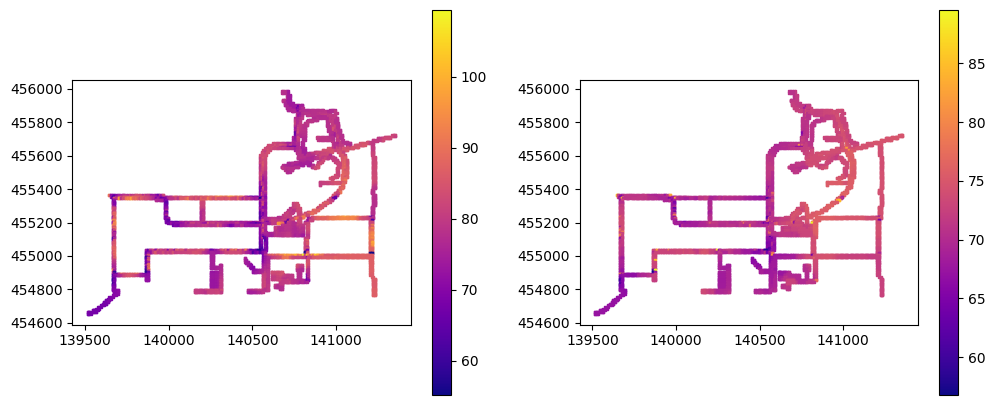

In [78]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,5))

m = get_new_model()
m.fit(gdf[x_cols].values, gdf[c_cols].values, gdf['dBA_raw'].values)
p = m.predict(**get_test_inputs(gdf_full))
gdf_full['pred'] = p
gdf_full[gdf_full['sub_area'] == 'Science Park'].plot(column='pred', legend=True, markersize=2, marker='s', ax=ax0, cmap=cmap)

m = get_new_model()
gdf_temp = gdf[gdf['dBA_raw_slt20'].notna()]
m.fit(gdf_temp[x_cols].values, gdf_temp[c_cols].values, gdf_temp['dBA_raw_slt20'].values)
p = m.predict(**get_test_inputs(gdf_full))
gdf_full['pred'] = p
gdf_full[gdf_full['sub_area'] == 'Science Park'].plot(column='pred', legend=True, markersize=2, marker='s', ax=ax1, cmap=cmap)